In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

# Torchvision libraries
from torchvision import datasets, models, transforms
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

# Other libraries
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os
import copy
import random

# Sklearn metrics for evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [2]:

import os

data_dir = "D:/Downloads/archive/chest_xray"
train_dir = os.path.join(data_dir, 'train')  # Correctly constructs the path
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

print(f"Train directory: {train_dir}")



Train directory: D:/Downloads/archive/chest_xray\train


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomGrayscale(p=0.1),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, transform=data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

In [5]:
batch_size = 32
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True, num_workers=0),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=0)
}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
class_names

['NORMAL', 'PNEUMONIA']

In [7]:
model = efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)

# Freeze most layers and add dropout in the classifier
for param in model.parameters():
    param.requires_grad = False
for param in model.features[6:].parameters():  # Unfreeze the last two blocks
    param.requires_grad = True

# Modify the classifier to fit the number of classes and increase dropout
num_ftrs = model.classifier[1].in_features  # Get the input features of the final layer
model.classifier = nn.Sequential(
    nn.Dropout(0.5),      # Dropout layer for regularization
    nn.Linear(num_ftrs, 512),  # Add an intermediate layer with 512 units
    nn.ReLU(),                 # Activation function 
    nn.Dropout(0.3),      # Another dropout layer
    nn.Linear(512, 2)     # Final layer for binary classification
)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [8]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Define optimizer with increased weight decay
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=5e-4)  # Increased weight decay

# Cosine annealing scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Early stopping and checkpoint parameters
patience = 5
epochs_without_improvement = 0
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

In [9]:
num_epochs = 100
accumulation_steps = 4  # Accumulate gradients over 4 batches
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training phase
    for i, (images, labels) in enumerate(tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{num_epochs}")):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass and loss calculation
        outputs = model(images)
        loss = criterion(outputs, labels) / accumulation_steps  # Normalize loss by accumulation steps

        # Backward pass
        loss.backward()
        
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()  # Update weights after accumulation_steps
            optimizer.zero_grad()

        running_loss += loss.item() * labels.size(0)

    train_loss = running_loss / dataset_sizes['train']
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloaders['val']:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * labels.size(0)
    
    val_loss = val_running_loss / dataset_sizes['val']
    val_losses.append(val_loss)
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement == patience:
            print("Early stopping triggered.")
            break

    # Step the scheduler
    scheduler.step()   

    # Print losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

# Load best model weights
model.load_state_dict(best_model_wts)

Epoch 9/100: 100%|███████████████████████████████████████████████████████████████████| 163/163 [29:59<00:00, 11.04s/it]


Early stopping triggered.


<All keys matched successfully>

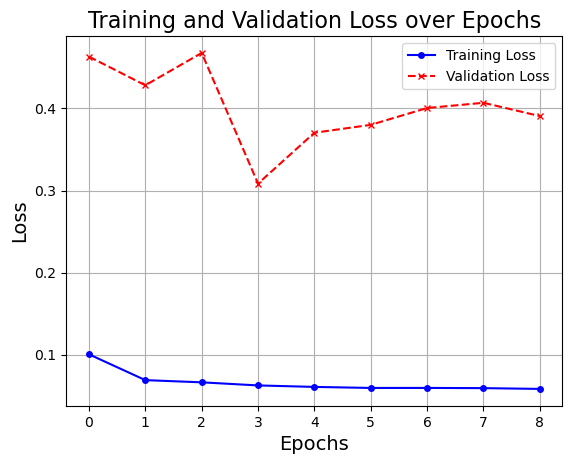

In [10]:
plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--', marker='x', markersize=4)

# Add title and labels
plt.title('Training and Validation Loss over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Show legend
plt.legend()

# Add grid for better readability
plt.grid(True)
plt.show()

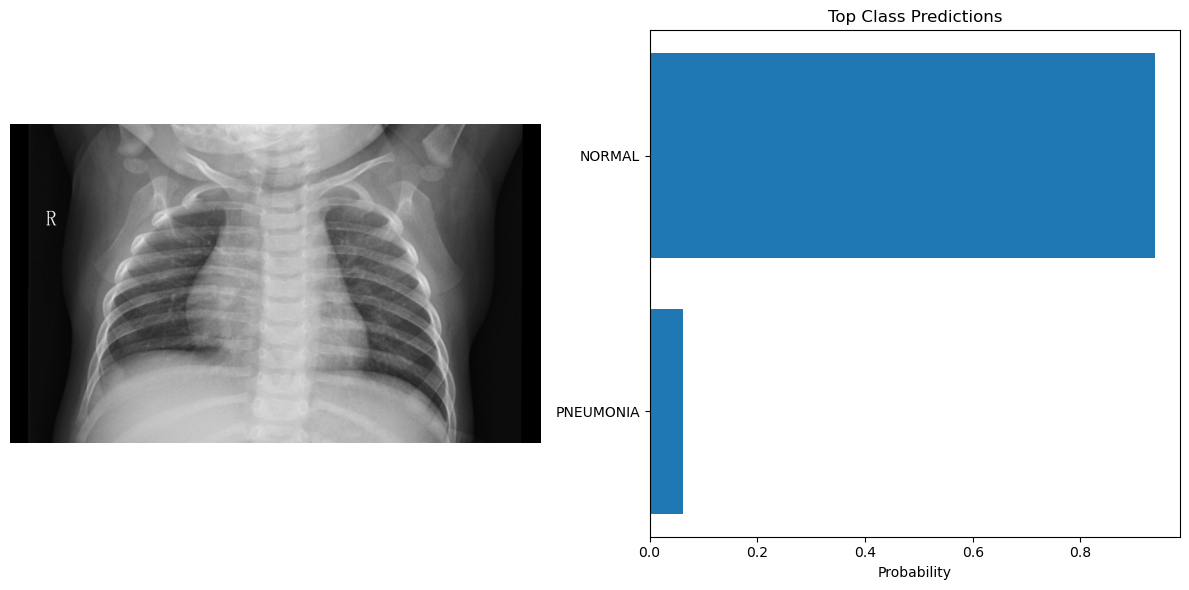

Image 1:
  Actual class: NORMAL
  Predicted class: NORMAL
------------------------------


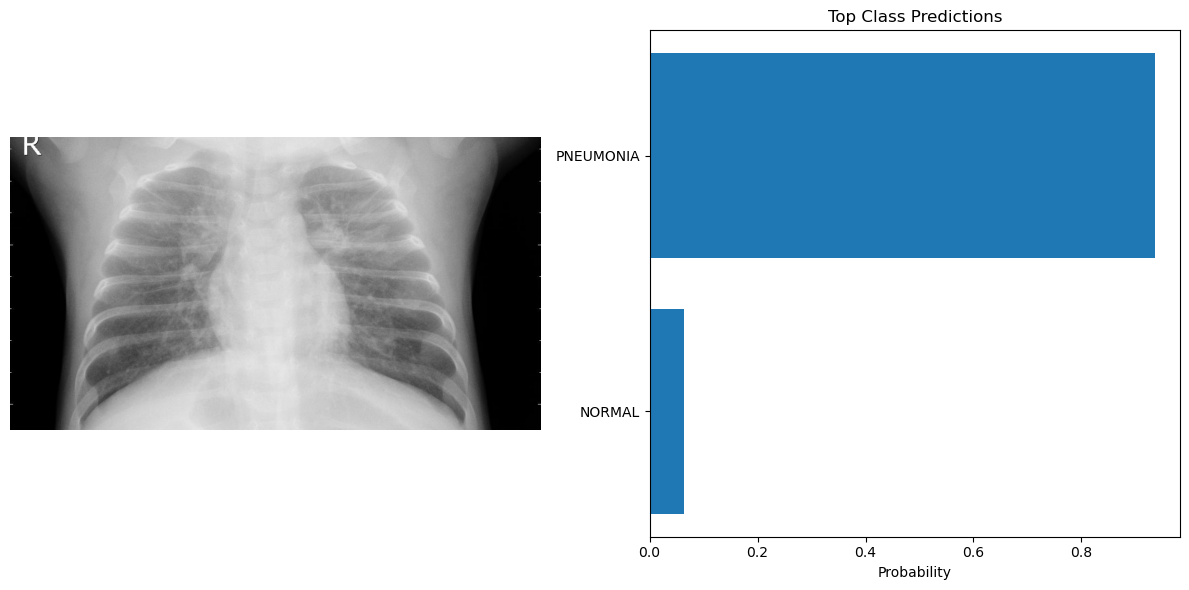

Image 2:
  Actual class: PNEUMONIA
  Predicted class: PNEUMONIA
------------------------------


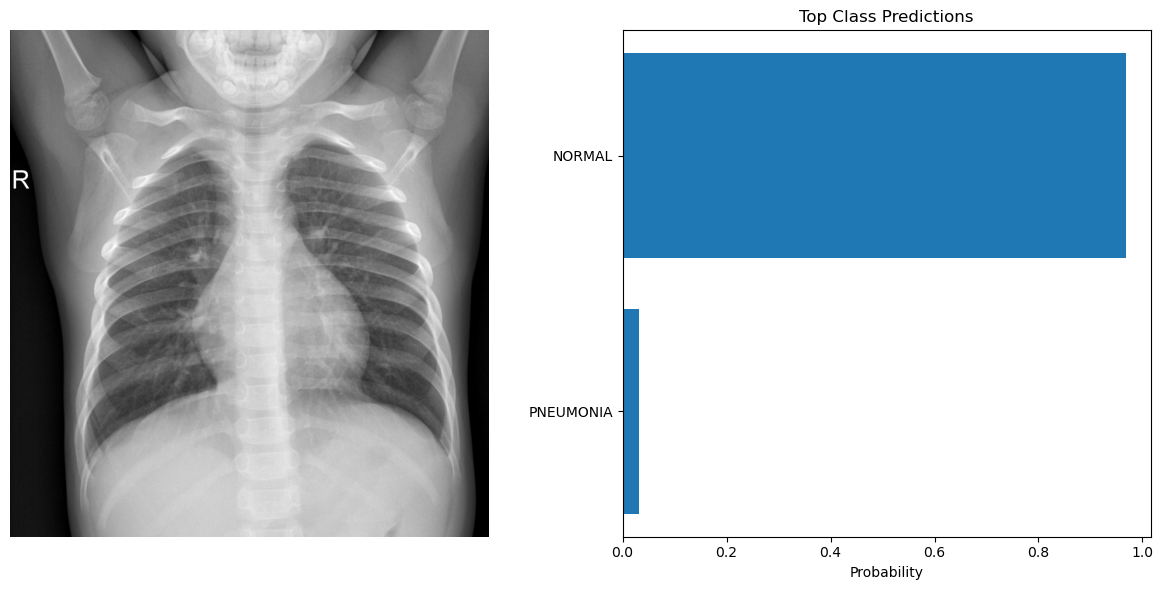

Image 3:
  Actual class: NORMAL
  Predicted class: NORMAL
------------------------------


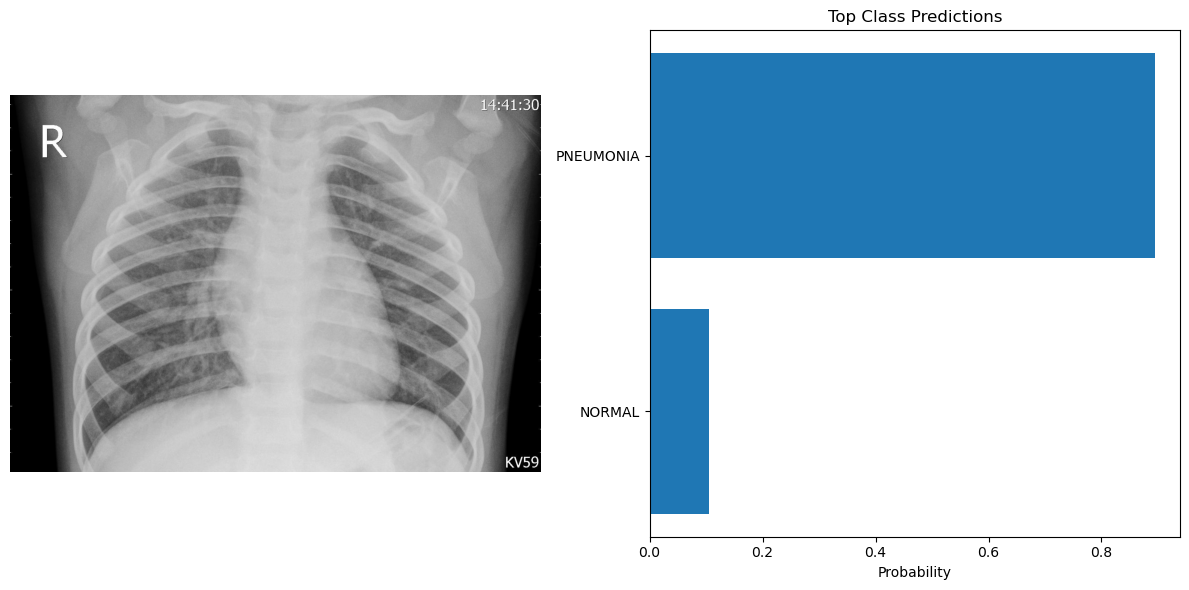

Image 4:
  Actual class: NORMAL
  Predicted class: PNEUMONIA
------------------------------


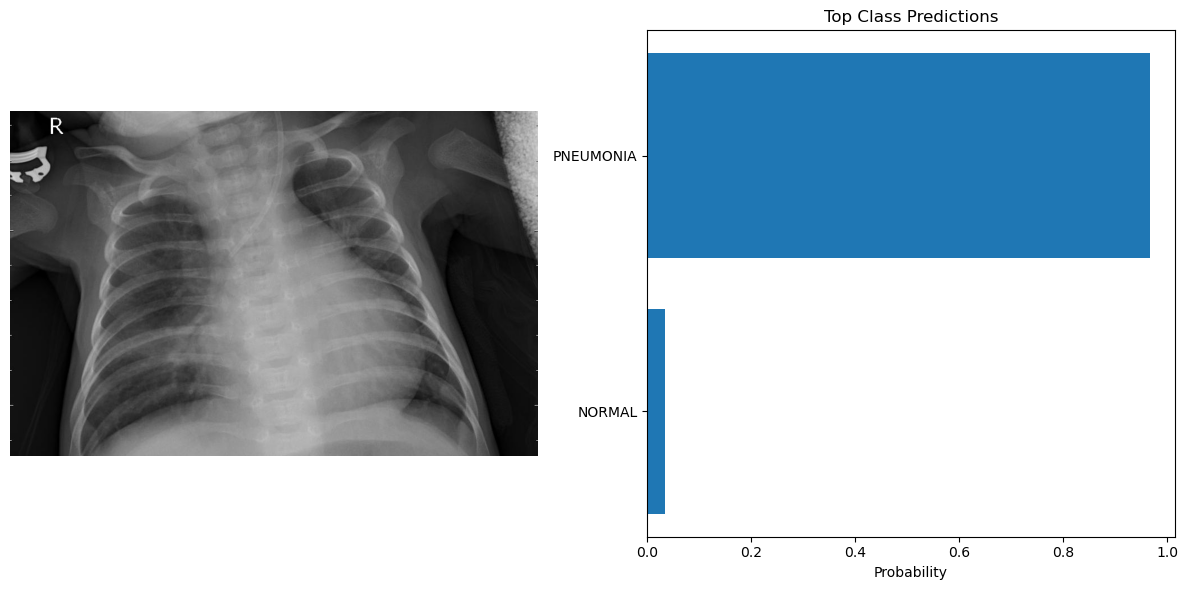

Image 5:
  Actual class: PNEUMONIA
  Predicted class: PNEUMONIA
------------------------------


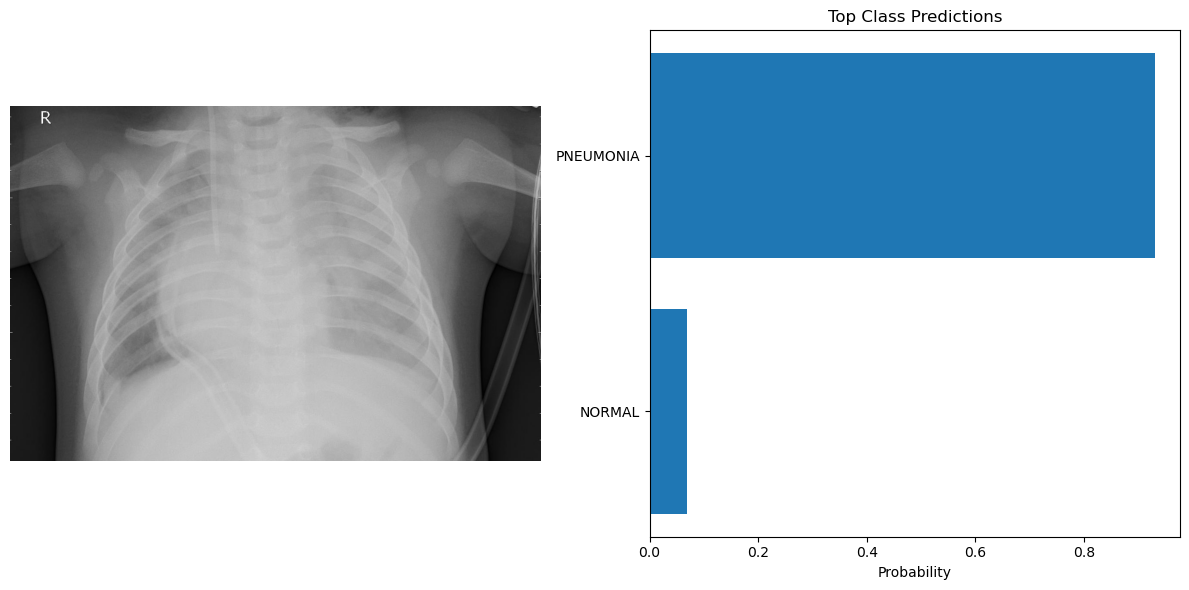

Image 6:
  Actual class: PNEUMONIA
  Predicted class: PNEUMONIA
------------------------------


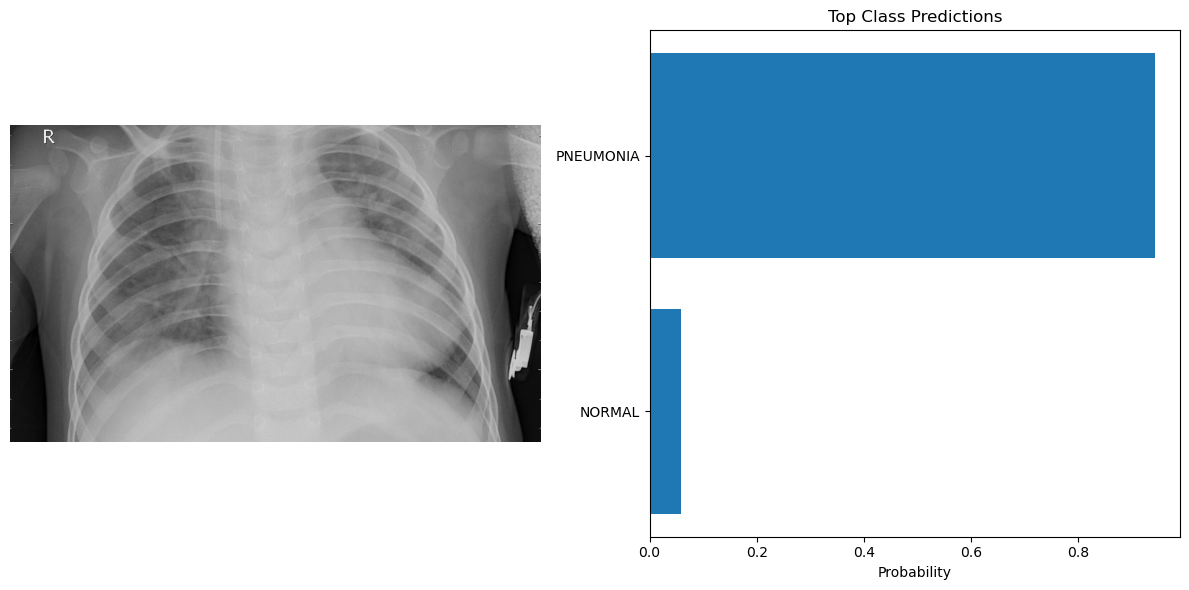

Image 7:
  Actual class: PNEUMONIA
  Predicted class: PNEUMONIA
------------------------------


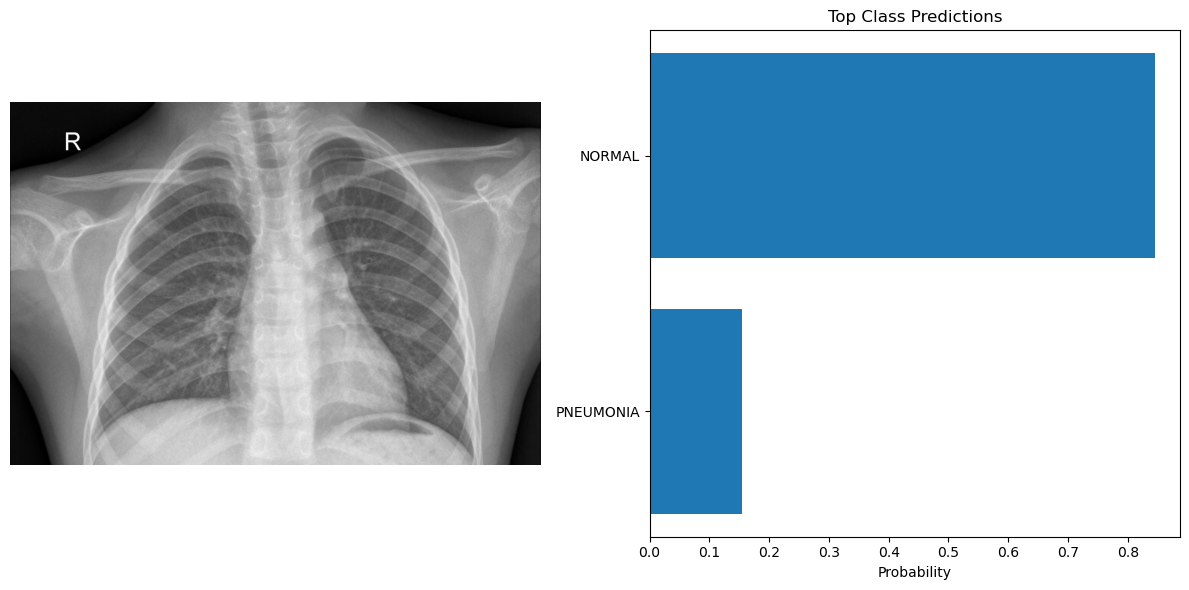

Image 8:
  Actual class: NORMAL
  Predicted class: NORMAL
------------------------------


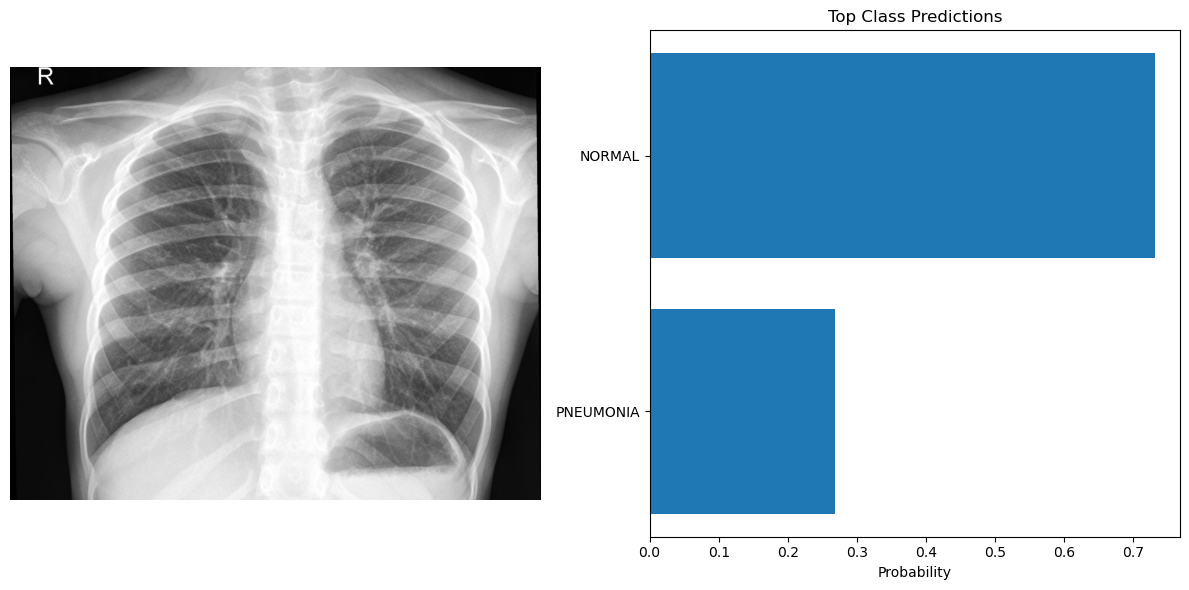

Image 9:
  Actual class: NORMAL
  Predicted class: NORMAL
------------------------------


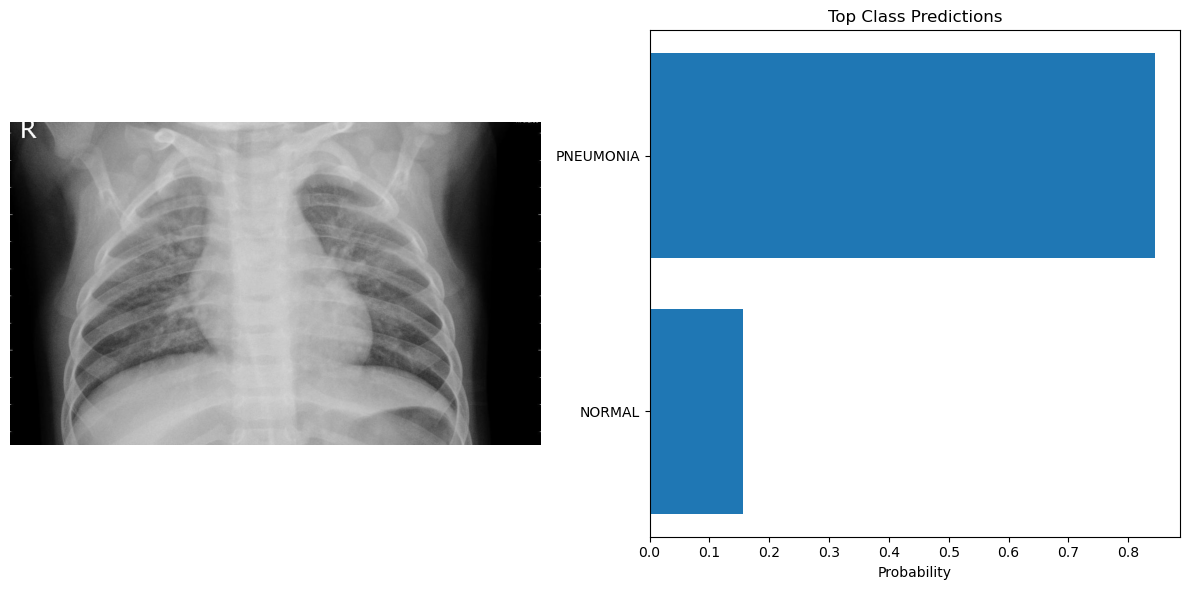

Image 10:
  Actual class: PNEUMONIA
  Predicted class: PNEUMONIA
------------------------------


In [12]:
def load_and_preprocess_image(image_path, transform):
    """
    Loads an image from the specified path, converts it to RGB format, applies transformations, 
    and prepares it as a tensor for model input.
    
    Args:
        image_path (str): The file path of the image to load.
        transform (torchvision.transforms.Compose): Transformations to apply to the image.
        
    Returns:
        tuple: Original PIL image and preprocessed image tensor ready for model input.
    """
    image = Image.open(image_path).convert("RGB")  # Open and convert image to RGB
    return image, transform(image).unsqueeze(0)     # Apply transformations and add batch dimension


# Prediction function with combined loading, preprocessing, and prediction
def predict_image(model, image_path, transform, device):
    """
    Loads and preprocesses an image, then uses the model to predict class probabilities.
    
    Args:
        model (torch.nn.Module): Trained model to use for prediction.
        image_path (str): Path to the image file to predict.
        transform (torchvision.transforms.Compose): Transformations to apply to the image.
        device (torch.device): Device to run the model on (CPU or GPU).
        
    Returns:
        tuple: Original image and class probabilities as a numpy array.
    """
    original_image, image_tensor = load_and_preprocess_image(image_path, transform)  # Load and preprocess image
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        image_tensor = image_tensor.to(device)  # Move image tensor to specified device
        outputs = model(image_tensor)           # Get model outputs
        probabilities = F.softmax(outputs, dim=1)  # Apply softmax to get class probabilities
    
    return original_image, probabilities.cpu().numpy().flatten()  # Return image and probabilities


# Visualization function for predictions
def visualize_predictions(image, probabilities, class_names, top_k=2):
    """
    Displays the original image alongside a bar chart of the top-k class predictions.
    
    Args:
        image (PIL.Image): The original image.
        probabilities (np.array): Array of class probabilities output by the model.
        class_names (list): List of class names corresponding to model output.
        top_k (int): Number of top predictions to display (default is 2 for binary classification).
    """
    top_k_idx = probabilities.argsort()[-top_k:][::-1]         # Get indices of top-k predictions
    top_classes = [class_names[i] for i in top_k_idx]          # Retrieve class names for top-k predictions
    top_probabilities = probabilities[top_k_idx]               # Get probabilities for top-k predictions

    # Plotting the original image and top-k predictions
    fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
    axarr[0].imshow(image)                                     # Display the original image
    axarr[0].axis("off")
    
    axarr[1].barh(top_classes, top_probabilities)              # Display bar chart for top-k predictions
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Top Class Predictions")
    axarr[1].invert_yaxis()                                    # Display highest probability at the top
    
    plt.tight_layout()
    plt.show()


# Function to select a random image from the test folder
def get_random_image_from_folder(folder_path):
    """
    Selects a random image from a specified folder structure where images are organized by class.
    
    Args:
        folder_path (str): Path to the root folder containing subfolders for each class.
        
    Returns:
        tuple: File path to a randomly selected image and the actual class label.
    """
    classes = os.listdir(folder_path)                          # List all class subfolders in the test folder
    random_class = random.choice(classes)                      # Choose a random class
    class_folder = os.path.join(folder_path, random_class)     # Path to chosen class folder
    image_files = os.listdir(class_folder)                     # List all images in the chosen class folder
    random_image_file = random.choice(image_files)             # Choose a random image from the class folder
    return os.path.join(class_folder, random_image_file), random_class  # Return image path and class


# Example usage to predict and visualize 10 random images
test_folder_path = "D:/Downloads/archive/chest_xray/test"  # Path to your test data
transform = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize images to match model input size
    transforms.ToTensor(),            # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize as per ImageNet standards
])

class_names = ["NORMAL", "PNEUMONIA"]  # Set class names for binary classification

# Loop to predict on 10 random images and visualize results
for i in range(10):  
    test_image_path, actual_class = get_random_image_from_folder(test_folder_path)  # Select random image
    original_image, probabilities = predict_image(model, test_image_path, transform, device)  # Make prediction
    visualize_predictions(original_image, probabilities, class_names)  # Visualize top predictions
    
    # Print actual and predicted class
    predicted_class_idx = probabilities.argmax()
    predicted_class = class_names[predicted_class_idx]
    print(f"Image {i+1}:")
    print(f"  Actual class: {actual_class}")
    print(f"  Predicted class: {predicted_class}")
    print("-" * 30)

Test Accuracy: 86.8590%
Precision: 0.8319
Recall: 0.9897
F1 Score: 0.9040
Confusion Matrix:
[[156  78]
 [  4 386]]


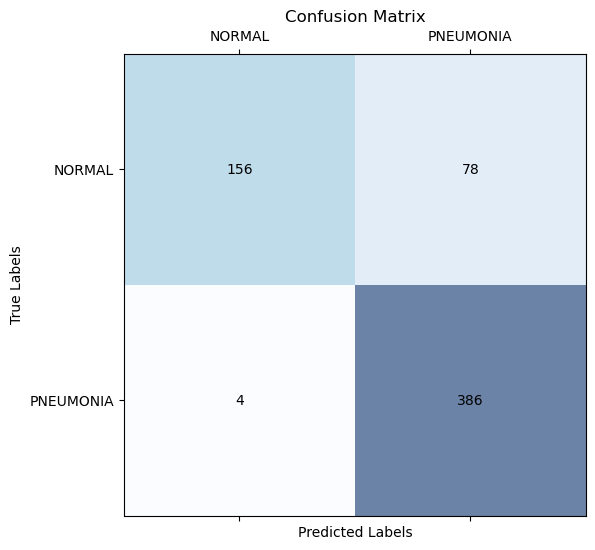

In [13]:
def evaluate_model(model, dataloader, class_names):
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            
            # Collect all predictions and labels for detailed metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = running_corrects.double() / len(dataloader.dataset) * 100
    print(f'Test Accuracy: {accuracy:.4f}%')

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    # Display confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Optionally, visualize the confusion matrix
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.6)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(ticks=[0, 1], labels=class_names)
    plt.yticks(ticks=[0, 1], labels=class_names)
    plt.show()

# Example usage:
class_names = ["NORMAL", "PNEUMONIA"]  # Define your class names
evaluate_model(model, dataloaders['test'], class_names)